# Houses Price Prediction of Karachi

--------

## Import Libraries

In [316]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import re

import warnings
warnings.filterwarnings('ignore')

--------

## Load Dataset

In [317]:
df = pd.read_csv('D:/DS Bootcamp/Machine Learning/Karachi House Price Prediction/Price-Prediction-of-Karachi-Houses/Karachi Houses Dataset.csv')
df.sample(5)

,property_id,purpose,city,location,beds,baths,area_yard,price,date_added
7500,Property_7501,Sale,Karachi,"DHA Phase 6, DHA Defence",5,6,"1,000 Sq. Yd.",24 Crore,NaN
927,Property_928,Sale,Karachi,"DHA Phase 6, DHA Defence",7,6,500 Sq. Yd.,11 Crore,NaN
2999,Property_3000,Sale,Karachi,"Gulshan-e-Iqbal - Block 1, Gulshan-e-Iqbal",6,6,240 Sq. Yd.,1.22 Crore,2025-04-24
226,Property_227,Sale,Karachi,"DHA Phase 6, DHA Defence",6,7,500 Sq. Yd.,14.5 Crore,2025-04-25
7866,Property_7867,Sale,Karachi,"Mohammad Ali Society, Gulshan-e-Iqbal Town",600 Sq. Yd.,NaN,NaN,23 Crore,NaN


----------

## Data Preprocessing

### Data Anomilies 

Correct the data typos and anomilies on the dataset

From location extract only the house location area socities
like Scheme 33, DHA etc

In [318]:
locations = ['DHA', 'Malir', 'Scheme 33', 'Naya Nazimabad', 'Gadap Town', 'North Nazimabad', 
             'Gulistan-e-Jauhar', 'Federal B Area', 'PECHS', 'Gulshan-e-Iqbal', 'Gulshan-e-Maymar', 
             'North Karachi', 'Shadman Town', 'Clifton', 'Askari 5', 'Surjani Town', 'Bahria', 'Scheme 1', 
             'Saima Villas', 'Saadi Garden', 'Karsaz', 'Saadi Town', 'Bufferzone', 'NHS Mauripur', 'KN Gohar Green', 
             'Gulshan-e-Roomi','Landhi','Falcon Complex', 'Saima Luxury', 'Jamshed Town','Amir Khusro', 'Ilyas Goth', 
             'Airport Road', 'Zamzama', 'Faisal Cantonment','Sindhi Muslim Society', 'Bath Island', 'Shahra-e-Faisal', 
             'Defence View', 'Shaheed Millat Road', 'Gulshan-e-Kaneez Fatima', 'Chapal Uptown']

def extract_location(location):
    for loc in locations:
        if loc in location:
            return loc
    return None

In [319]:
df['society'] = df['location'].apply(extract_location)

During scrapping the data scraped had some errors, like in baths and beds columns some values of area_yard were included

Correct the baths column 

In [320]:
area_condition = df['baths'].str.contains('Sq. Yd.', na=False)

df.loc[area_condition, 'area_yard'] = df.loc[area_condition, 'baths']

df.loc[area_condition, 'baths'] = None

Correct the beds column

In [321]:
area_condition = df['beds'].str.contains('Sq. Yd.', na=False)

df.loc[area_condition, 'area_yard'] = df.loc[area_condition, 'beds']

df.loc[area_condition, 'beds'] = None

Convert the area_yard into sq_feet

In [322]:
df['area_yard_clean'] = df['area_yard'].str.replace(',', '', regex=False)

df['area_num'] = df['area_yard_clean'].str.extract('(\d+)', expand=False).astype(float)

df['area_in_sqft'] = df['area_num'] * 9

Convert the price to numeric values

In [323]:
def convert_price(value):
    if isinstance(value, float) or isinstance(value, int):
        return value  
    value = value.strip()

    if 'Arab' in value:
        num = float(value.replace('Arab', '').strip())
        return num * 1_000_000_000
    elif 'Crore' in value:
        num = float(value.replace('Crore', '').strip())
        return num * 10_000_000
    elif 'Lakh' in value:
        num = float(value.replace('Lakh', '').strip())
        return num * 100_000
    else:
        return float(value)
    
df['price'] = df['price'].apply(convert_price)

Change the numeric data column type into int

In [324]:
num = ['beds', 'baths']

for i in num:
    df[i]=pd.to_numeric(df[i], errors='coerce')

Remove unnecessary columns

In [325]:
df.drop(columns=['purpose','city','location','area_yard','area_num', 'area_yard_clean','date_added'],inplace=True)

Rename the numeric price column to price

In [326]:
df.rename(columns={'numeric_price':'price'}, inplace=True)

-------

### Handle missing values

In [327]:
print('Missing values in the dataset:')
(df.isnull().sum() / len(df) * 100).sort_values(ascending=False)

Missing values in the dataset:


baths           7.800416
beds            6.644491
price           4.000000
society         3.135135
property_id     0.000000
area_in_sqft    0.000000
dtype: float64

**Steps**
- Check is data is MCAR or not
- Check the distribution of data before and after imputation

We have a beautifull library called missingo, which can help us to see the values are MCAR or not.

<Axes: >

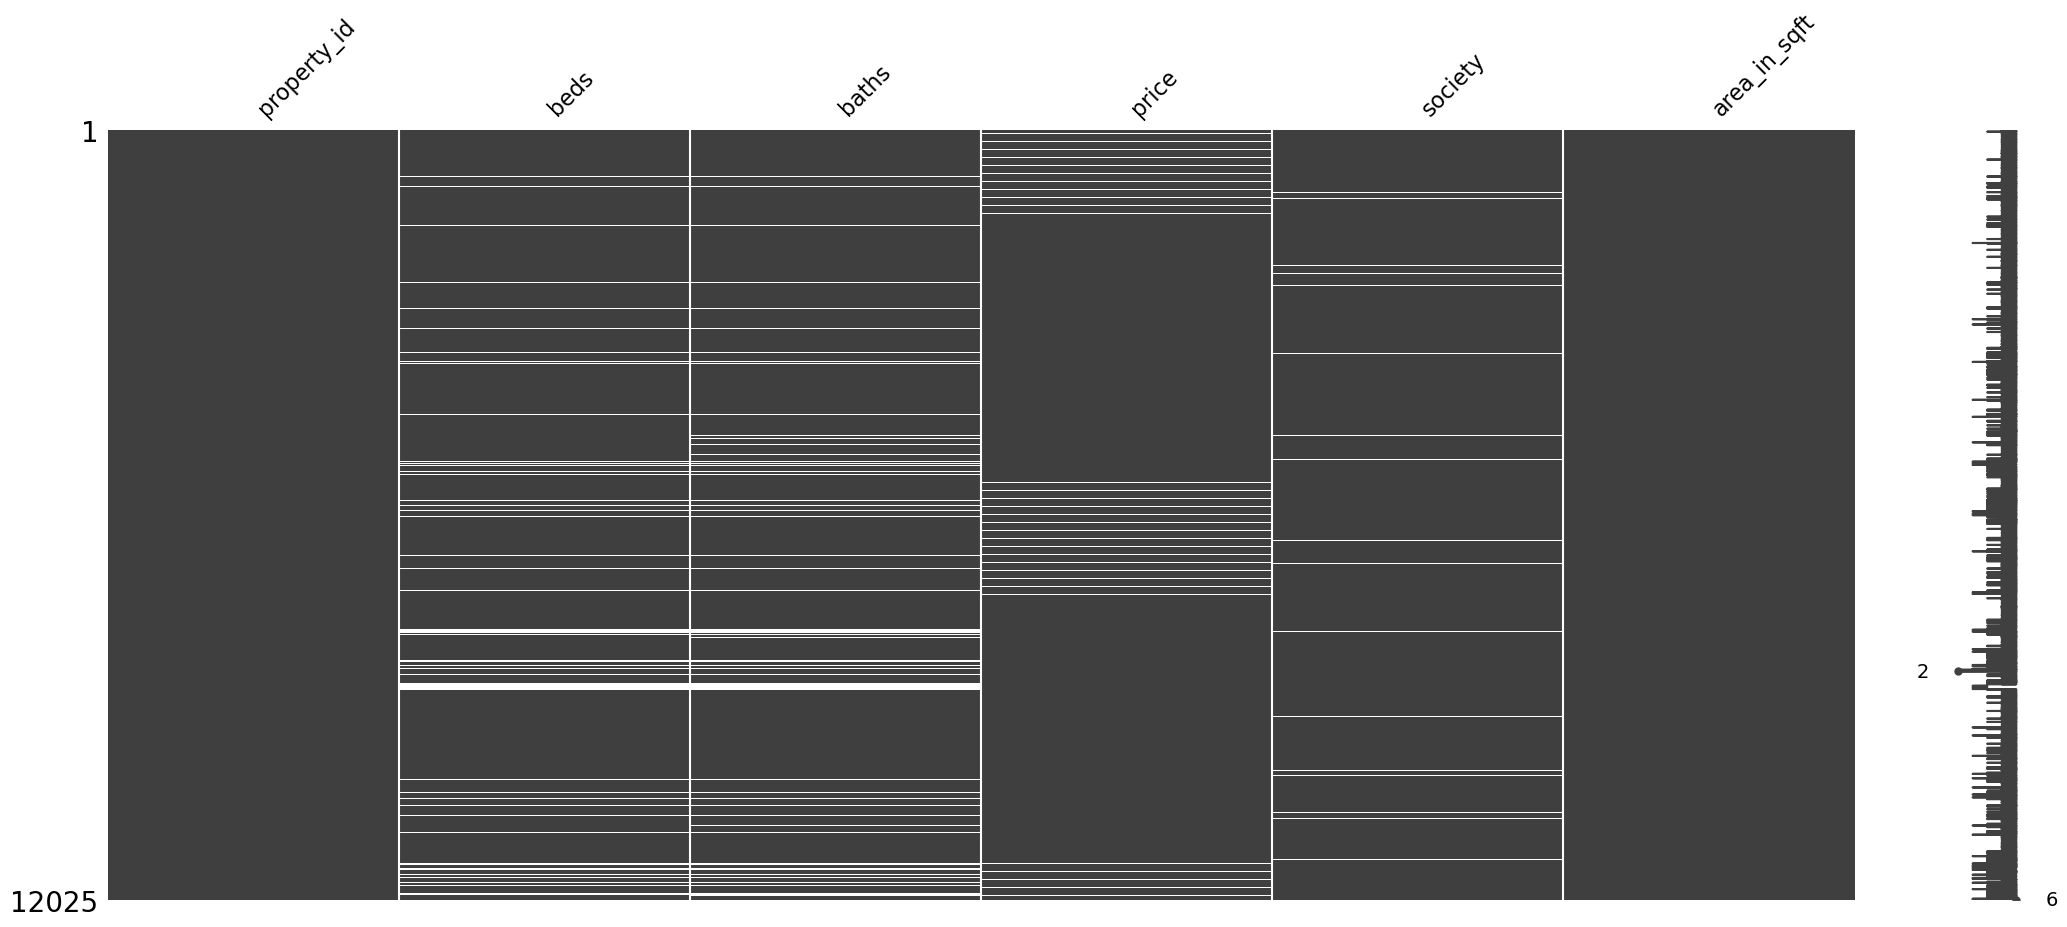

In [328]:
msno.matrix(df)

- First, we drop the rows with missing values in the target column. Filling these missing values could introduce bias into the model.
- In the society column, missing values cannot be filled reliably because we lack sufficient information about which houses belong to which society.

In [329]:
df.dropna(subset=['price', 'society'], inplace=True)

remain features missing values are MCAR.
Now check the Distribution of these columns

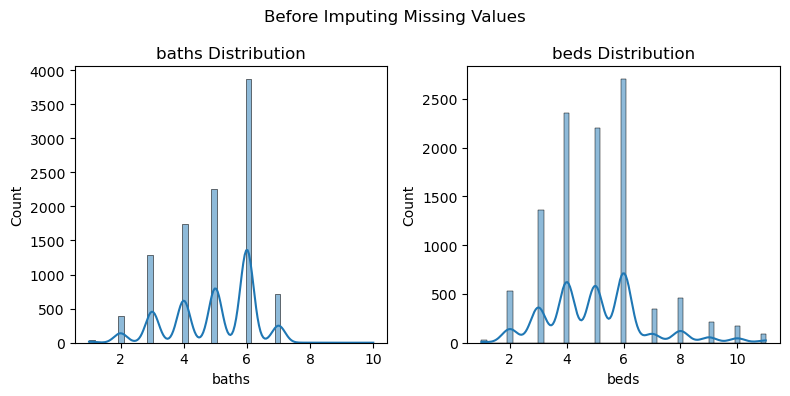

In [330]:
num_missing = ['baths','beds']

plt.figure(figsize=(8,4))
for i, col in enumerate(num_missing):
    plt.subplot(1,2,i+1)
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'{col} Distribution')
    plt.suptitle('Before Imputing Missing Values')
plt.tight_layout()
plt.show()


- As our baths feature values from 1 - 10, 
- Beds feature values from 1-11.

- In baths we use mode as the 6 apears more in the data so it can't effect on distribution 

In [331]:
df['baths'].fillna(df['baths'].mode()[0], inplace=True)

Approximately 6.6% of values are missing in the beds column. To preserve the original distribution, we fill missing values evenly with 4, 5, or 6

In [332]:
fill_values = [4, 5, 6]
missing_beds = df[df['beds'].isna()].index
df.loc[missing_beds, 'beds'] = np.random.choice(fill_values, size=len(missing_beds), replace=True)

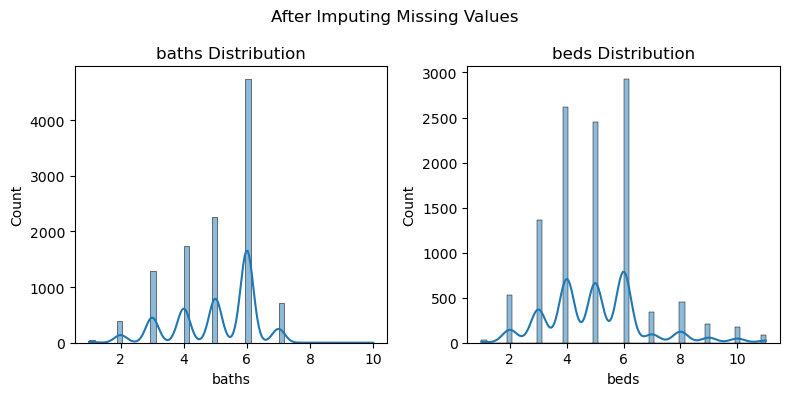

In [333]:
plt.figure(figsize=(8,4))
for i, col in enumerate(num_missing):
    plt.subplot(1,2,i+1)
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'{col} Distribution')
    plt.suptitle('After Imputing Missing Values')
plt.tight_layout()
plt.show()

In [334]:
change_type = ['beds', 'baths', 'price']
for i in change_type:
    df[i] = df[i].astype('int64')

--------

### Data Summary

In [335]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 11177 entries, 0 to 12024
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   property_id   11177 non-null  object 
 1   beds          11177 non-null  int64  
 2   baths         11177 non-null  int64  
 3   price         11177 non-null  int64  
 4   society       11177 non-null  object 
 5   area_in_sqft  11177 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 869.3+ KB


,beds,baths,price,area_in_sqft
count,11177.000000,11177.000000,1.117700e+04,11177.000000
mean,5.011720,5.044108,8.338548e+07,3142.147446
std,1.702389,1.293784,8.971227e+07,3118.576117
min,1.000000,1.000000,1.400000e+06,45.000000
25%,4.000000,4.000000,2.600000e+07,1125.000000
50%,5.000000,5.000000,5.600000e+07,2250.000000
75%,6.000000,6.000000,1.070000e+08,4500.000000
max,11.000000,10.000000,1.600000e+09,171000.000000


**Beds**
- The number of beds in the houses from 1 to 11.

**Baths**
- The number of bathrooms in the houses from 1 to 10.

**Date_added**
- The data is from 2024 - 2025

**Area_in_sqft**
- 45 - 171000, as these values are outliers, we will remove them as on website the max house are in sq ft is 18000

**Price**
- The min house price is 14 lac and max house price is 1.6 Arab

-----------

There are no duplicated Rows in the dataset

In [336]:
df.duplicated().sum()

0

----------

### Handle Outliers

Make a boxplot of numeric columns to check if there are any outliers.

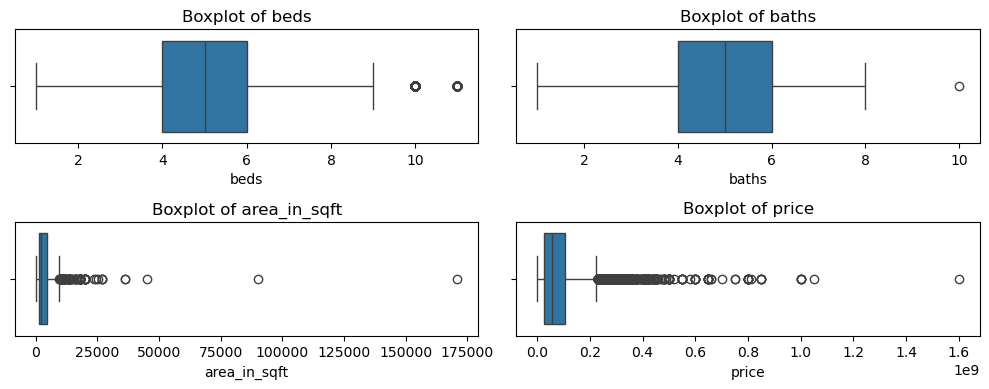

In [337]:
outlier = ['beds', 'baths','area_in_sqft', 'price']

plt.figure(figsize=(10, 4))
for i, col in enumerate(outlier):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


- Remove the baths column outlier as on website there are no more than 8 baths in a house
- Remove the area_in_sqft column outliers as on website there are no more than 30000 sqft in a house
- Remianing columns has a valid outlier so we didn't remove them.

In [338]:
df = df[df['baths'] < 8]

In [339]:
df = df[df['area_in_sqft'] <= 30000]

In [340]:
df = df[df['price'] <= 800000000]

----------

## Exploratory Data Analysis

### Univarite Analysis

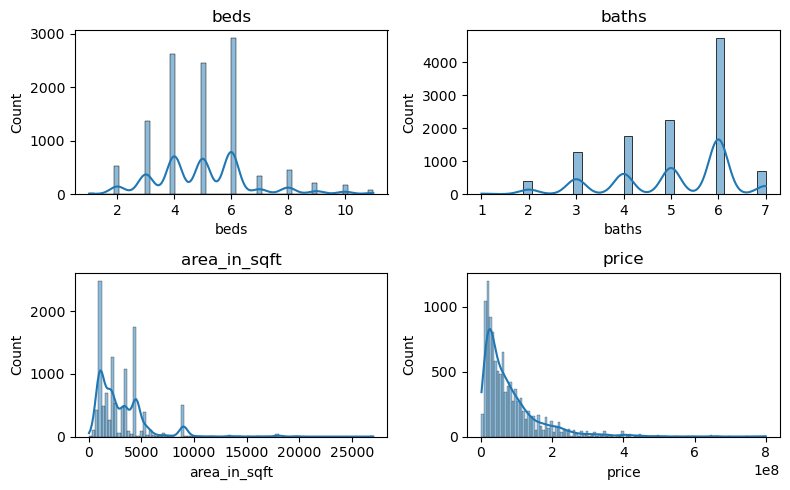

In [341]:
hist = ['beds', 'baths', 'area_in_sqft', 'price']

plt.figure(figsize=(8, 5))
for i, col in enumerate(hist):
    plt.subplot(2, 2, i+1)
    sns.histplot(data=df, x =df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

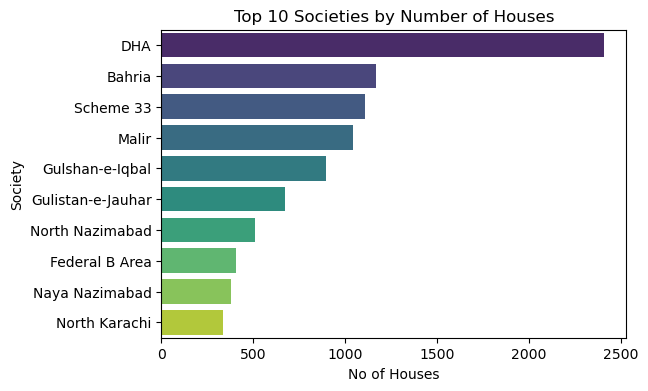

In [342]:
top_societies = df['society'].value_counts().head(10).reset_index()
top_societies.columns = ['society', 'count']

plt.figure(figsize=(6, 4))
sns.barplot(data=top_societies, y='society', x='count', palette='viridis')
plt.title('Top 10 Societies by Number of Houses')
plt.xlabel('No of Houses')
plt.ylabel('Society')
plt.show()

DHA societies have the highest number of listings compared to other societies 

---------

### Bivariate Analysis

**Beds vs Price**

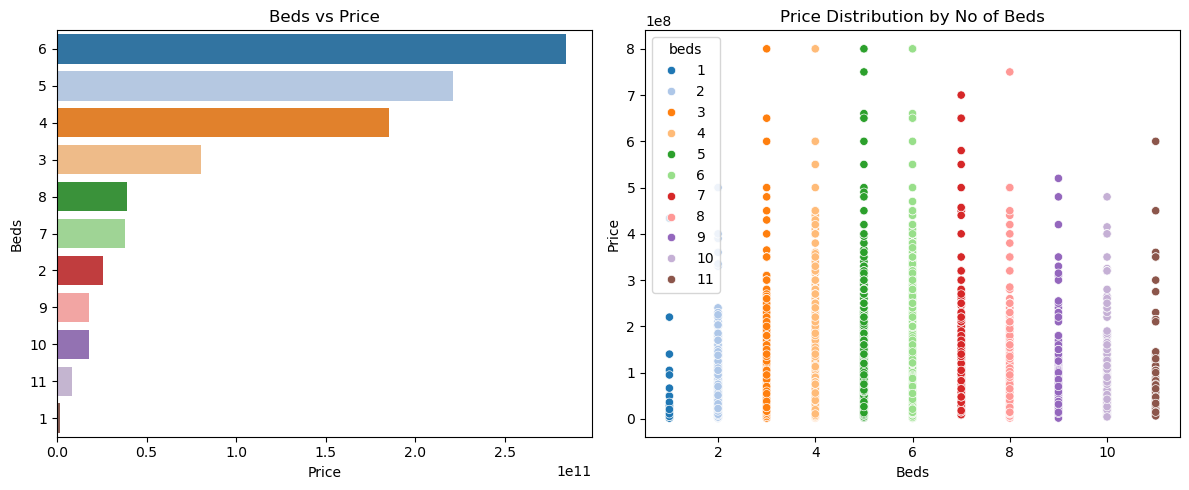

In [343]:
bed_price = df.groupby('beds')['price'].sum().sort_values(ascending=False).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(data=bed_price, y='beds', x='price', ax=axes[0], orient='h', 
            order=bed_price['beds'], palette='tab20')
axes[0].set_title('Beds vs Price')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Beds')

sns.scatterplot(data=df, x='beds', y='price', ax=axes[1], 
                hue='beds',palette='tab20')
axes[1].set_title('Price Distribution by No of Beds')
axes[1].set_ylabel('Price')
axes[1].set_xlabel('Beds')

plt.tight_layout()
plt.show()

- 4, 5, and 6-bed houses tend to have higher prices than others 
- We see a clear trend of price increase from 3 beds to 7 beds.

Baths vs Price

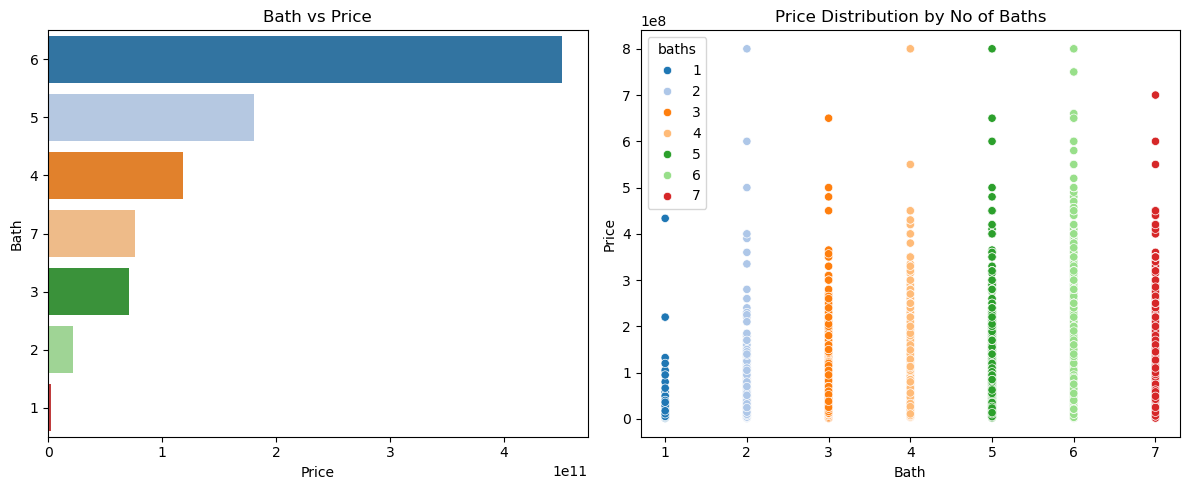

In [344]:
bath_price = df.groupby('baths')['price'].sum().sort_values(ascending=False).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(data=bath_price, y='baths', x='price', ax=axes[0], orient='h', 
            order=bath_price['baths'], palette='tab20')
axes[0].set_title('Bath vs Price')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Bath')

sns.scatterplot(data=df, x='baths', y='price', ax=axes[1], 
                hue='baths',palette='tab20')
axes[1].set_title('Price Distribution by No of Baths')
axes[1].set_ylabel('Price')
axes[1].set_xlabel('Bath')

plt.tight_layout()
plt.show()

- 4, 5, and 6-bath houses have higher prices than the others.
- There is a clear trend where as the number of baths increases, the house prices also tend to increase.

**Area Sq Ft vs Price**

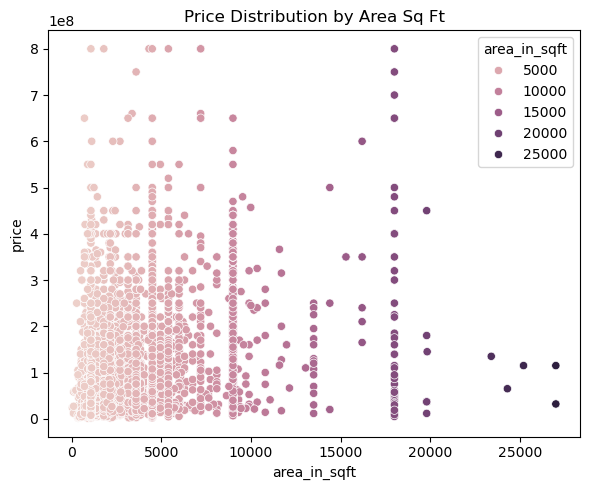

In [345]:
plt.figure(figsize=(6,5))
sns.scatterplot(data=df, x='area_in_sqft', y='price',hue='area_in_sqft')
plt.title('Price Distribution by Area Sq Ft')
plt.tight_layout()
plt.show()

- There are clusters of houses ranging from 500 sqft to 5000 sqft, and their prices vary. 
- Interestingly, some smaller houses are priced higher than larger ones, while in other cases, the larger houses are priced more.
- This suggests that price is not solely dependent on square footage.

**Society vs Price**

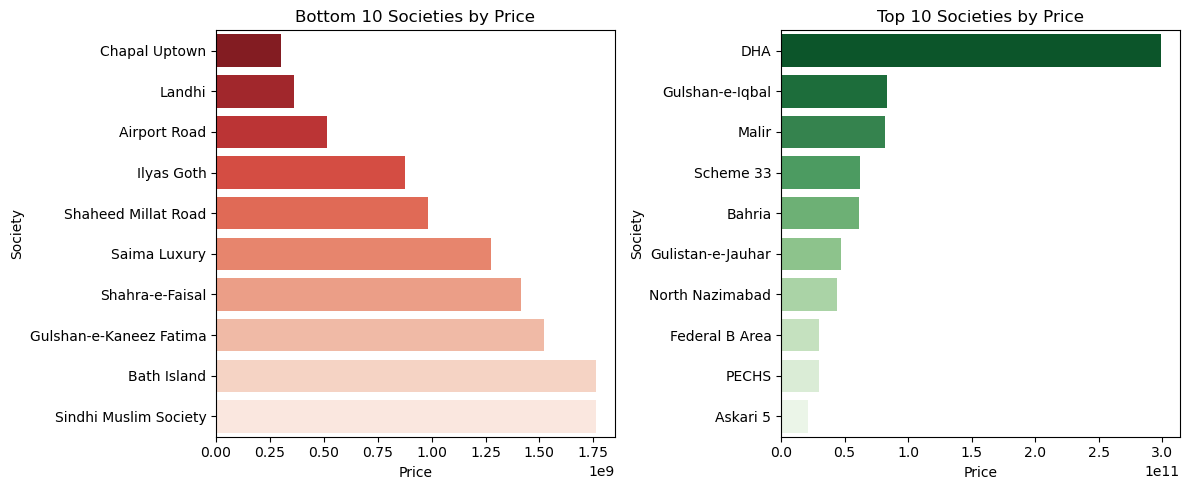

In [346]:
society_price = df.groupby('society')['price'].sum()

top10 = society_price.nlargest(10).sort_values(ascending=False)
bottom10 = society_price.nsmallest(10).sort_values(ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=bottom10.values, y=bottom10.index, ax=axes[0], palette='Reds_r')
axes[0].set_title('Bottom 10 Societies by Price')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Society')

sns.barplot(x=top10.values, y=top10.index, ax=axes[1], palette='Greens_r')
axes[1].set_title('Top 10 Societies by Price')
axes[1].set_xlabel('Price')
axes[1].set_ylabel('Society')

plt.tight_layout()
plt.show()

- Chapal Uptown, Landhi, Airport Road, and Shahra-e-Faisal are well-known societies but have relatively lower average house prices. This may be due to fewer property listings in these areas, which can limit price variation and affect the average.
- On the other hand, DHA, Gulshan-e-Iqbal, Malir, Scheme 33, and Bahria are also popular societies but show higher average prices, likely because of a larger number of property listings, which increases market activity and raises the average

------------

### Multivariate Analysis

- Low price: less than 25th percentile < 25,800,000
- Medium price: between 25th and 75th percentile = 25,800,000 to 106,500,000
- High price: greater than 75th percentile > 106,500,000



In [347]:
bins = [0, 2.58e7, 1.065e8, float('inf')]
labels = ['Low', 'Medium', 'High']

df['price_category'] = pd.cut(df['price'], bins=bins, labels=labels, include_lowest=True)

**Pairplot**

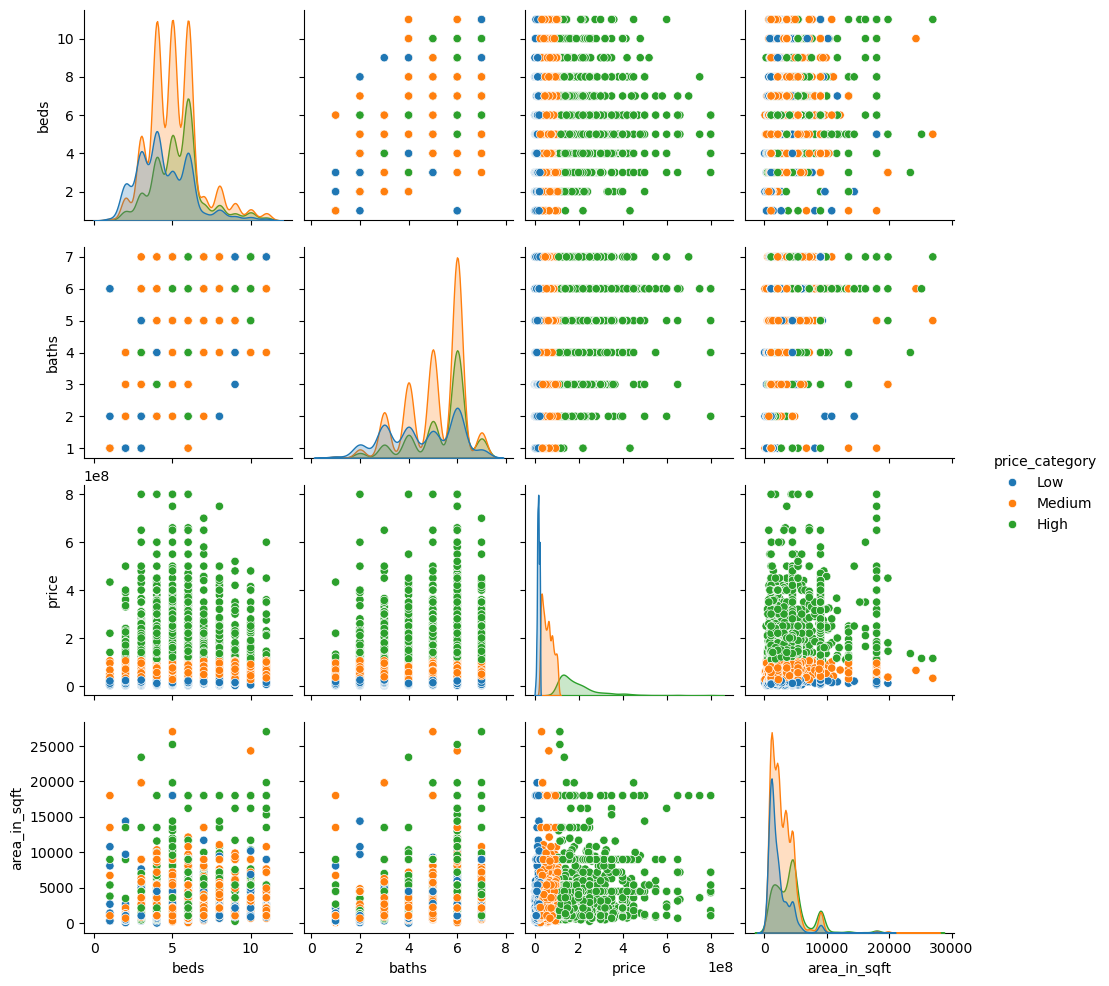

In [348]:
sns.pairplot(df, hue='price_category')
plt.show()

----

**Feature Engineering**

As we see that features are not powerful to predict the price of house, so we add some new features that help to predict the price of houses.

Price per square foot is a real estate metric that tells you how much you're paying for each square foot of property area.

In [349]:
df['price/sqft'] = df['price'] / df['area_in_sqft']

Avg price by society tells us that which society is more expensive and which is less expensive.

In [350]:
df['avgprice_society'] = df.groupby('society')['price'].transform('mean')

The area per bed feature helps the model understand the space allocated per bedroom, which can improve prediction accuracy by capturing room spaciousness and housing quality.

In [351]:
df['area/bed'] = df['area_in_sqft'] / df['beds']

The price per bed feature represents the total price of the house divided by the number of bedrooms, capturing how much each bedroom costs on average, a useful indicator of property value and luxury level.

In [352]:


df['price/bed'] = (df['price/sqft'] * df['area_in_sqft']) / df['beds']


-----------

**Correlation Matrix**

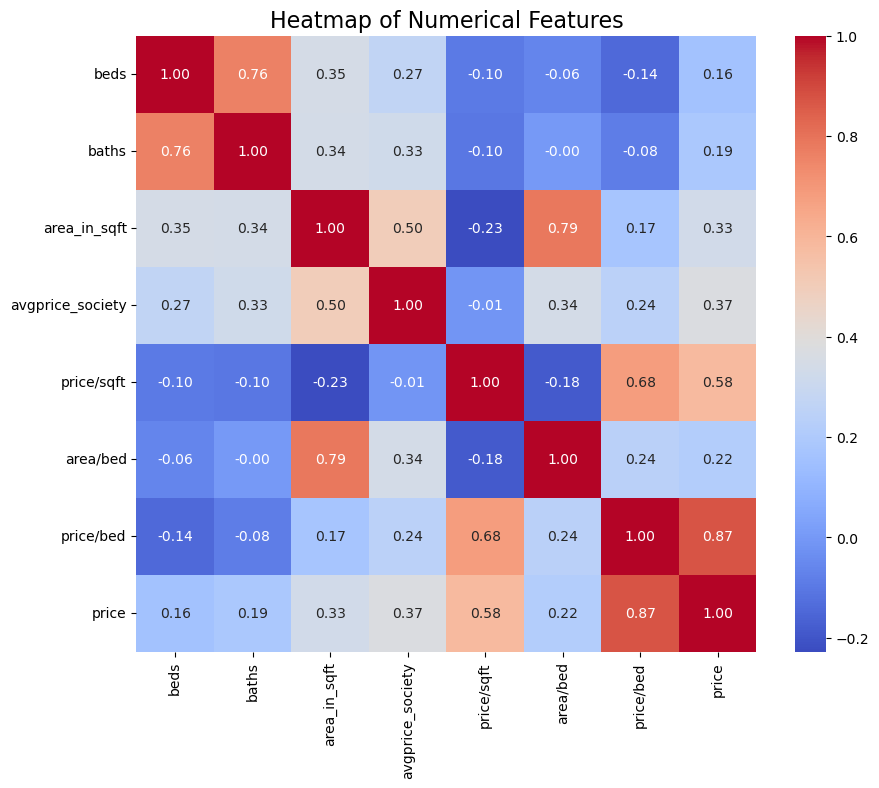

In [353]:
num = ['beds', 'baths', 'area_in_sqft','avgprice_society','price/sqft','area/bed','price/bed','price']

plt.figure(figsize = (10, 8))
sns.heatmap(df[num].corr(), annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.title('Heatmap of Numerical Features', fontsize = 16)

plt.show()

**Input Features correlation with Output**
- price/sqft and price/bed are high correlated with price


**Input Features correlation with input features**
- beds are highly correlated with baths, so i removed baths to handle multicollinearity

----------

**Regplot**

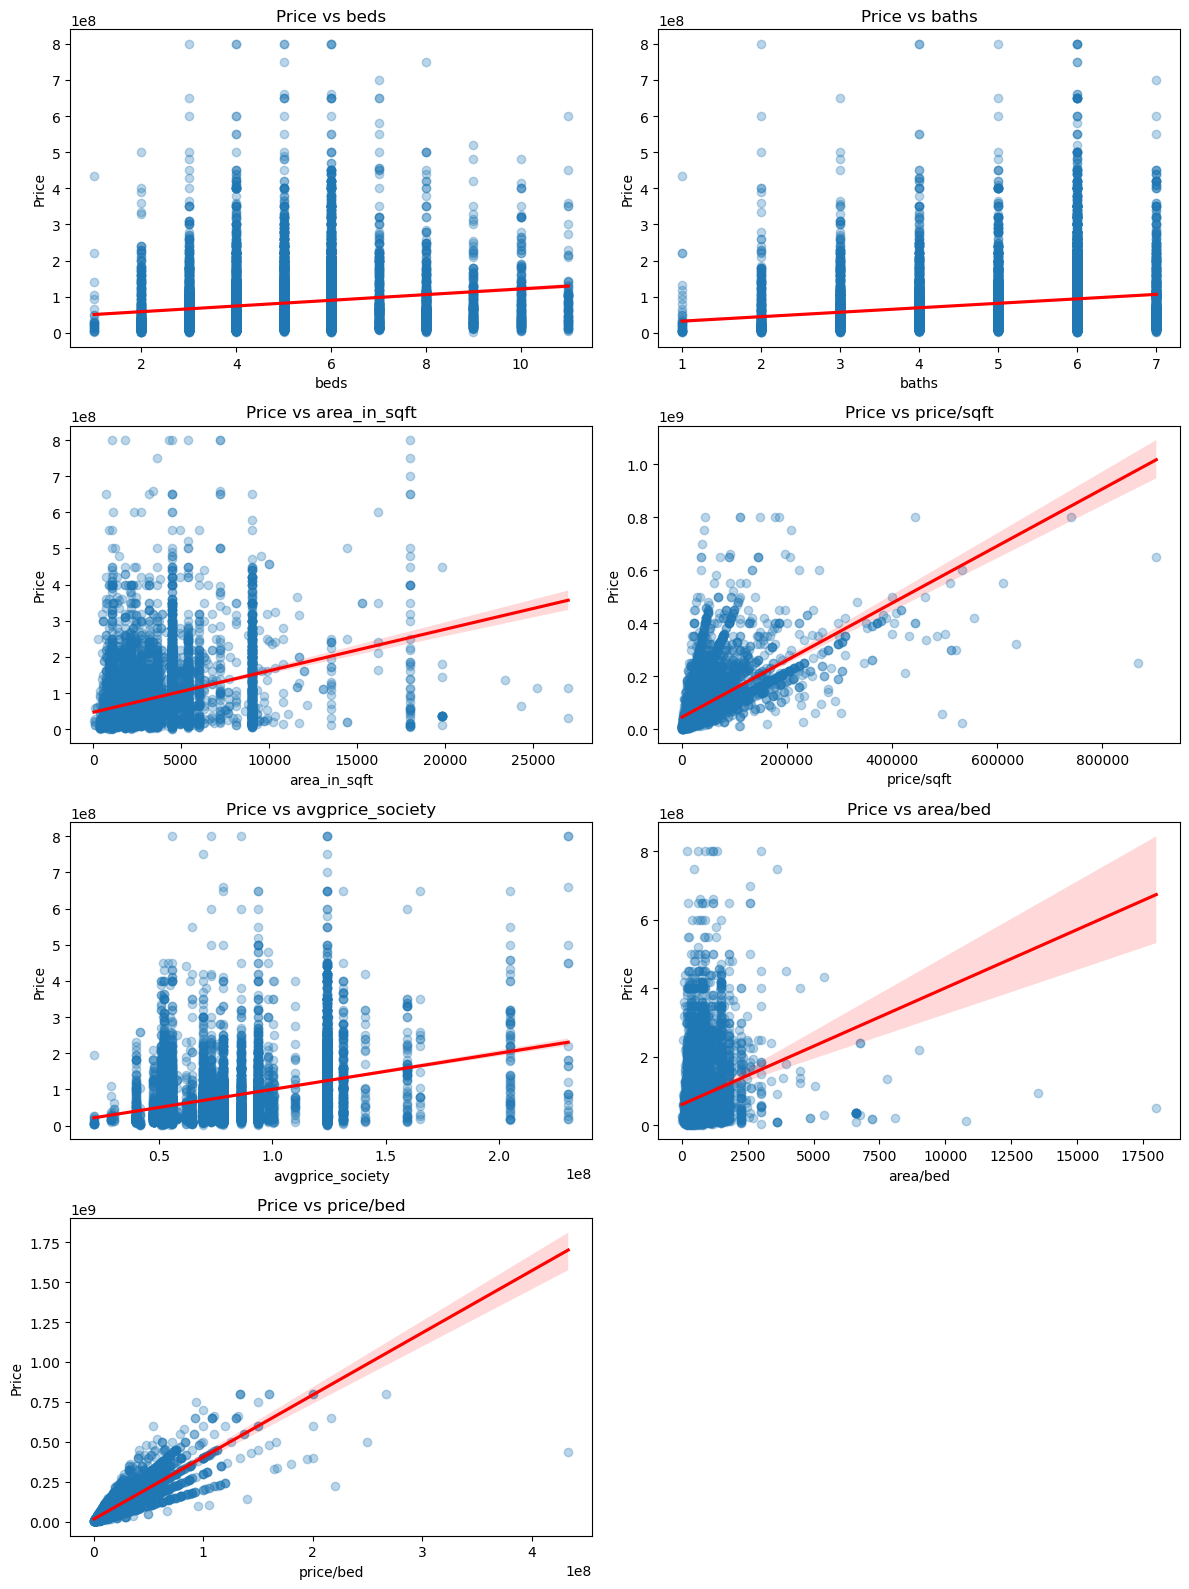

In [354]:
numeric_cols = df.select_dtypes(include='number').columns

numeric_cols = [col for col in numeric_cols if col != 'price']

n_cols = 2
n_rows = (len(numeric_cols) + 1) // n_cols
plt.figure(figsize=(n_cols * 6, n_rows * 4))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.regplot(data=df, x=col, y='price', scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    plt.title(f'Price vs {col}')
    plt.xlabel(col)
    plt.ylabel('Price')

plt.tight_layout()
plt.show()

----------------

Drop irrelevant features that didn't help in prediction.

In [355]:
df = df.drop(columns=['property_id', 'price_category', 'baths'])

## Model Training

- We have a categorical column called society so firstly use one hot encoding on it.
- Remaining Numerical columns use Standard Scaler.

My plane is we make a pipeline of all these steps and then we can use it any where

In [356]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

In [357]:
pre = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ['society']),
    ('num', StandardScaler(), ['area_in_sqft','price/sqft', 'avgprice_society','area/bed','price/bed'])
], remainder='passthrough')


In [358]:
X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [359]:
lr = Pipeline([
        ('preprocessing', pre),
        ('regressor', LinearRegression())
    ])

In [360]:
lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['society']),
                                                 ('num', StandardScaler(),
                                                  ['area_in_sqft', 'price/sqft',
                                                   'avgprice_society',
                                                   'area/bed',
                                                   'price/bed'])])),
                ('regressor', LinearRegression())])

Pred on both train and test data to check if the model is overfitting or not.

Find 
- MAE
- RMSE
- R2_Score
- Adjusted r2_score

**Model Evaluation**

In [361]:
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * ((n - 1) / (n - k - 1))

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

n_train, k = X_train.shape
n_test = X_test.shape[0]

mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)
adj_r2_train = adjusted_r2(r2_train, n_train, k)

mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)
adj_r2_test = adjusted_r2(r2_test, n_test, k)

In [362]:
print("Train Metrics:")
print(f"MAE: {mae_train:.2f}, RMSE: {rmse_train:.2f}, R2: {r2_train:.3f}, Adjusted R2: {adj_r2_train:.3f}")

print("\nTest Metrics:")
print(f"MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}, R2: {r2_test:.3f}, Adjusted R2: {adj_r2_test:.3f}")

Train Metrics:
MAE: 16063254.58, RMSE: 31168565.88, R2: 0.865, Adjusted R2: 0.865

Test Metrics:
MAE: 16271549.36, RMSE: 30222011.00, R2: 0.873, Adjusted R2: 0.873


The overall model performance appears strong. Let's perform cross-validation (CV) to ensure the results are consistent and not overfitted

----------

In [363]:
from sklearn.model_selection import cross_validate

In [364]:
cv = cross_validate(lr,X, y,n_jobs=-1, cv=5,                     
                    scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2'],return_train_score=True)

print("CV Results:")
print(f"Train MAE: {-np.mean(cv['train_neg_mean_absolute_error']):.2f}")
print(f"Test MAE:  {-np.mean(cv['test_neg_mean_absolute_error']):.2f}")
print(f"Train RMSE: {-np.mean(cv['train_neg_root_mean_squared_error']):.2f}")
print(f"Test RMSE:  {-np.mean(cv['test_neg_root_mean_squared_error']):.2f}")
print(f"Train R2: {np.mean(cv['train_r2']):.3f}")
print(f"Test R2:  {np.mean(cv['test_r2']):.3f}")

CV Results:
Train MAE: 16066394.91
Test MAE:  16285372.30
Train RMSE: 30784530.33
Test RMSE:  32207725.83
Train R2: 0.868
Test R2:  0.854


Great to see the results are same as the model predicts

-------

Make a Prediction func that predict the price of house by taking input from user.


In [365]:
def predict_price(society, area_in_sqft, beds, pipeline, df):

    avg_price = df[df['society'] == society]['price/sqft'].mean() if not df[df['society'] == society].empty else 0
    area_per_bed = area_in_sqft / beds if beds else 0
    price_per_bed = area_per_bed * avg_price
    
    data = pd.DataFrame({'beds': [beds],'society': [society],'area_in_sqft': [area_in_sqft],'price/sqft': [avg_price],
                         'avgprice_society': [avg_price],  'area/bed': [area_per_bed],'price/bed': [price_per_bed]})
    predicted_price = pipeline.predict(data)[0]
    
    return round(predicted_price, 2)

In [366]:
society = input("Enter the society name: ")
area_in_sqft = float(input("Enter the area in square feet: "))
beds = int(input("Enter the number of bedrooms: "))

predicted_price = predict_price(society, area_in_sqft, beds, pipeline=lr, df=df)

print(f"House Price of '{beds} beds' in '{society}' with '{area_in_sqft}' square feet area is: '{str(int(predicted_price / 100000))} Lakhs'")

House Price of '5 beds' in 'Scheme 33' with '1800.0' square feet area is: '587 Lakhs'


-----------

**Further Improvements**
- Feature Enhancement incorporate additional relevant features to improve model understanding.
- Advanced Modeling experiment with ensemble methods like XGBoost, Gradient Boosting Regressor for potentially better performance on non-linear relationships.
- Error Reduction fine-tune hyperparameters, use cross-validation, and explore regularization or stacking techniques to minimize prediction error.